In [1]:
from astroquery.gaia import Gaia
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

# Omega-Centauri

In [2]:
#Convert RA in hms to dd and Dec in dms to dd

def convert_RA(RA):
    hms=[float(i) for i in RA.split()]
    return 15*(hms[0]+hms[1]/60+hms[2]/3600)

def convert_Dec(Dec):
    dms=[float(i) for i in Dec.split()]
    if dms[0]>0:
        return dms[0]+dms[1]/60+dms[2]/3600
    return dms[0]-(float(dms[1])/60)-(float(dms[2])/3600)

#Omega Centauri Coordinates
ra=convert_RA('13 26 47')
dec=convert_Dec('-47 28 46')
print(ra,dec)

201.69583333333333 -47.47944444444445


In [3]:
query = '''
SELECT top 50000 ra, dec, pmra,pmdec,parallax,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,DISTANCE(
    POINT(201.7, -47.48),
    POINT(ra, dec)) AS ang_sep
FROM gaiadr3.gaia_source
WHERE 1 = CONTAINS(
    POINT(201.7, -47.48),
    CIRCLE(ra, dec, 1))
AND parallax BETWEEN 0 and 0.3
AND ruwe<1.4
ORDER BY ang_sep ASC
'''
job = Gaia.launch_job_async(query)
r = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [4]:
mask=((r['ra']-201.7)**2+(r['dec']+47.48)**2)**0.5<15/60
r=r[mask]
r

ra,dec,pmra,pmdec,parallax,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,ang_sep
deg,deg,mas / yr,mas / yr,mas,mag,mag,mag,
float64,float64,float64,float64,float64,float32,float32,float32,float64
201.69827934724552,-47.475785634305836,-2.584226175148525,-5.808020081447826,0.2686016612304623,12.389305,12.838928,11.433256,0.004371878376847594
201.69298924473438,-47.47791998424896,-2.932274555757079,-7.946284325169325,0.09444141552125548,12.062796,12.857582,10.967266,0.0051747375448430895
201.69210891161217,-47.48256589341627,-1.8689418214293596,-7.386628180732734,0.1777618107932458,11.172258,11.899366,10.231465,0.00591820491277194
201.6974176051781,-47.47432961158139,-3.097463598116799,-7.1645596685391695,0.16839687606092307,12.118034,12.652305,11.212482,0.005932935498265383
201.70194026927552,-47.485970454200356,-3.2372579284825225,-6.9304551433357515,0.022706154150173505,12.953372,13.371292,12.10985,0.0061127493250247205
201.7074908713157,-47.47528236544928,-2.392854798267808,-6.578666783083334,0.17237527180798343,11.065382,11.885047,10.159468,0.0069202005149709405
...,...,...,...,...,...,...,...,...
201.6844248468115,-47.23135757271616,-7.143084718459357,-0.024691210669237757,0.25501344254067004,19.371973,19.73662,18.947657,0.2488662010914752


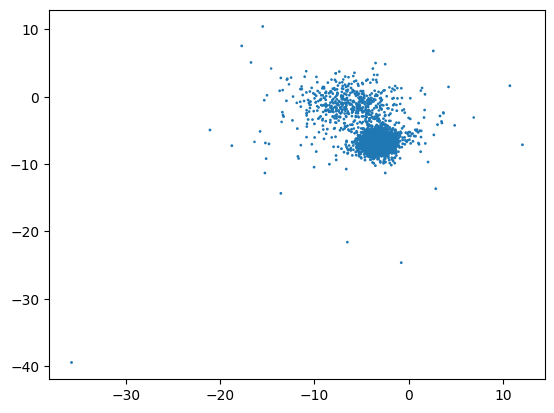

In [5]:
plt.scatter(r['pmra'],r['pmdec'],s=0.05*r['phot_g_mean_mag'])
plt.show()

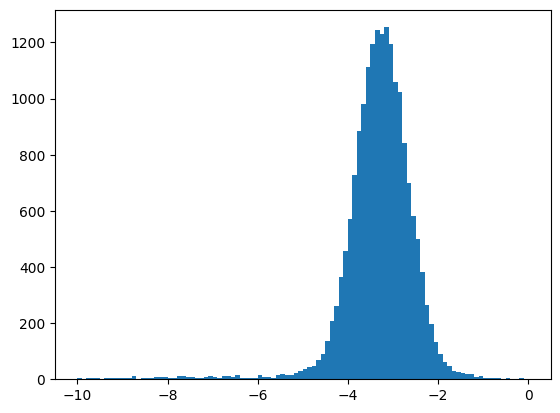

In [6]:
pmra=r['pmra']
counts,bins=np.histogram(pmra,range=[-10,0],bins=100)
plt.hist(pmra,range=[-10,0],bins=100)
plt.show()

In [7]:
from scipy.stats import norm

x_array=[]
for i in range(len(bins)-1):
    x_array.append((bins[i]+bins[i+1])/2)

from scipy.optimize import curve_fit

def gaussian(x,disp,amp,mu,sigma):
    return disp+amp*norm.pdf(x,mu,sigma)

popt,pcov=curve_fit(gaussian,x_array,counts)

In [8]:
pmra_mean=popt[2]
std=popt[3]

filter_up=pmra>(pmra_mean-3*std)
filter_down=pmra<(pmra_mean+3*std)

filter_pmra=np.logical_and(filter_up,filter_down)

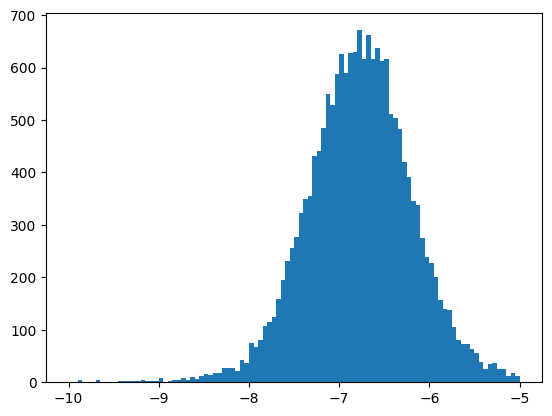

In [9]:
pmdec=r['pmdec']
counts,bins=np.histogram(pmdec,range=[-10,-5],bins=100)
plt.hist(pmdec,range=[-10,-5],bins=100)
plt.show()

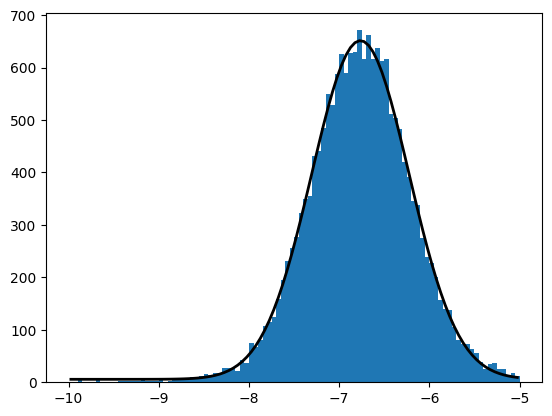

In [10]:
x_array=[]
for i in range(len(bins)-1):
    x_array.append((bins[i]+bins[i+1])/2)

popt,pcov=curve_fit(gaussian,x_array,counts,p0=(0,1000,-7,0.1))


plt.plot(x_array,gaussian(x_array,popt[0],popt[1],popt[2],popt[3]),linewidth=2,color='black')
plt.hist(pmdec,range=[-10,-5],bins=100)

plt.show()

In [11]:
pmdec_mean=popt[2]
std=popt[3]

filter_up=pmdec>(pmdec_mean-3*std)
filter_down=pmdec<(pmdec_mean+3*std)

filter_pmdec=np.logical_and(filter_up,filter_down)
filter_final=np.logical_and(filter_pmra,filter_pmdec)
data_wc=r[filter_final]

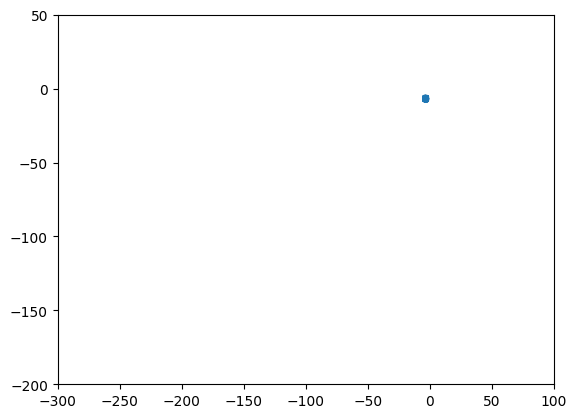

In [12]:
plt.scatter(data_wc['pmra'],data_wc['pmdec'],s=0.05*data_wc['phot_g_mean_mag'])
plt.xlim(-300,100)
plt.ylim(-200,50)
plt.show()

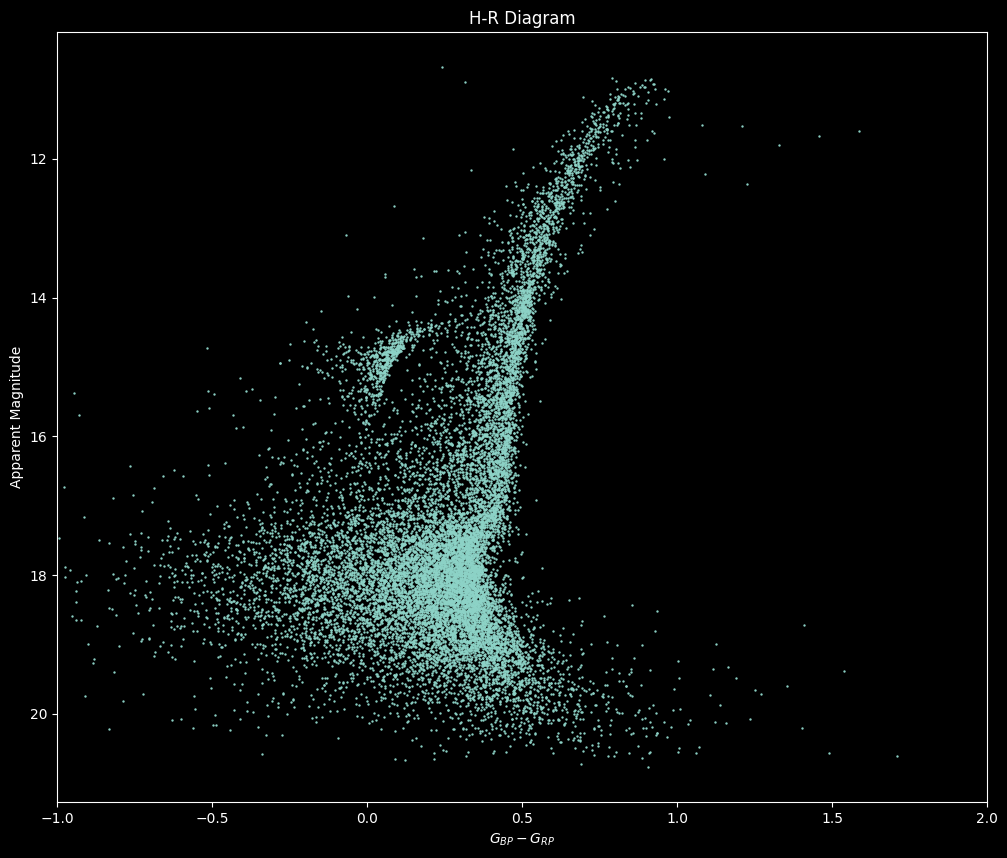

In [13]:
data_wc=data_wc[data_wc['parallax']>0]
app_mag=data_wc['phot_g_mean_mag']   
xaxis=data_wc['phot_bp_mean_mag']-data_wc['phot_g_mean_mag']               

with plt.style.context('dark_background'):
    plt.figure(figsize=(12,10))
    plt.scatter(xaxis,app_mag,s=0.5)
    plt.xlabel('$G_{BP}-G_{RP}$')
    plt.ylabel('Apparent Magnitude')
    plt.xlim(-1,2)
    plt.gca().invert_yaxis()
    plt.title('H-R Diagram')
plt.show()

### Distance estimation

In [37]:
abs_mag_rr_lyrae=4.83-2.5*np.log10(45)
dist=10*np.power(10,(14.5-abs_mag_rr_lyrae)/5)
dist
# good estimate!

5762.437883032625

In [22]:
from astropy.io import ascii
isodata=ascii.read('distance_estimation_isochrone.txt',delimiter=' ')

In [24]:
isodata[0:5]

Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,McoreTP,C_O,period0,period1,period2,period3,period4,pmode,Mloss,tau1m,X,Y,Xc,Xn,Xo,Cexcess,Z,mbolmag,Gmag,G_BPmag,G_RPmag
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0019443,-0.9,10.07918,0.0900000036,1.0816895926,0.09,-3.253,3.437,5.345,1,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-2.68e-17,0.0,0.744,0.254,0.0003523,9.504e-05,0.000862,-1.0,0.001959,12.903,14.263,16.883,12.857
0.0019443,-0.9,10.07918,0.0968389809,1.1441453234,0.097,-3.093,3.4595,5.307,1,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-4.93e-17,0.0,0.7433,0.2548,0.0003523,9.504e-05,0.000862,-1.0,0.001959,12.503,13.684,15.863,12.347
0.0019443,-0.9,10.07918,0.1000000015,1.1711064122,0.1,-3.023,3.4694,5.29,1,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-8.55e-17,0.0,0.7429,0.2551,0.0003523,9.504e-05,0.000862,-1.0,0.001959,12.327,13.43,15.428,12.127
0.0019443,-0.9,10.07918,0.1199999973,1.3193154249,0.12,-2.743,3.503,5.224,1,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-1.61e-16,0.0,0.741,0.257,0.0003523,9.504e-05,0.0008621,-1.0,0.001959,11.627,12.467,13.949,11.291
0.0019443,-0.9,10.07918,0.1400000006,1.4384526719,0.14,-2.556,3.5215,5.178,1,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-2.4e-16,0.0,0.7394,0.2586,0.0003523,9.504e-05,0.0008621,-1.0,0.001959,11.161,11.868,13.14,10.762


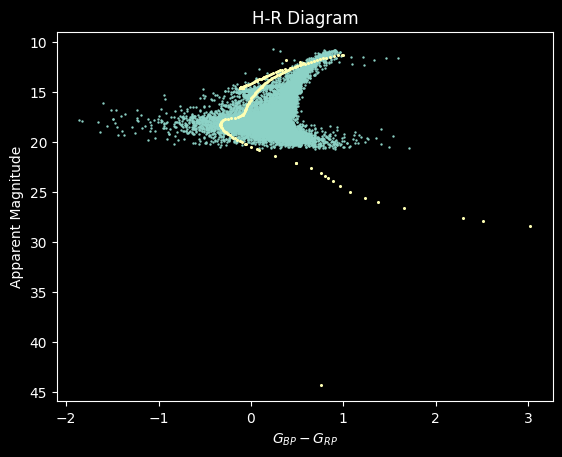

In [34]:
with plt.style.context('dark_background'):
    plt.scatter(xaxis,app_mag,s=0.5)
    plt.scatter((isodata['G_BPmag']-isodata['G_RPmag'])-1,isodata['Gmag']+14.2,s=1.5)
    plt.xlabel('$G_{BP}-G_{RP}$')
    plt.ylabel('Apparent Magnitude')
    plt.gca().invert_yaxis()
    plt.title('H-R Diagram')
plt.show()

In [35]:
# Use distance modulus to calculate estimated distance since vertical shift is only due to distance
# 14.2=5log10(d/10)
dist_estimate=10*np.power(10,2.84)
dist_estimate
#not too bad of an estimate of 5240 pc

6918.309709189362

### Metallicity Estimation

In [47]:
#metallicities=[-1.5,-1.2,-0.9,-0.6,-0.3]

In [45]:
age12=ascii.read('12.txt',delimiter=' ')

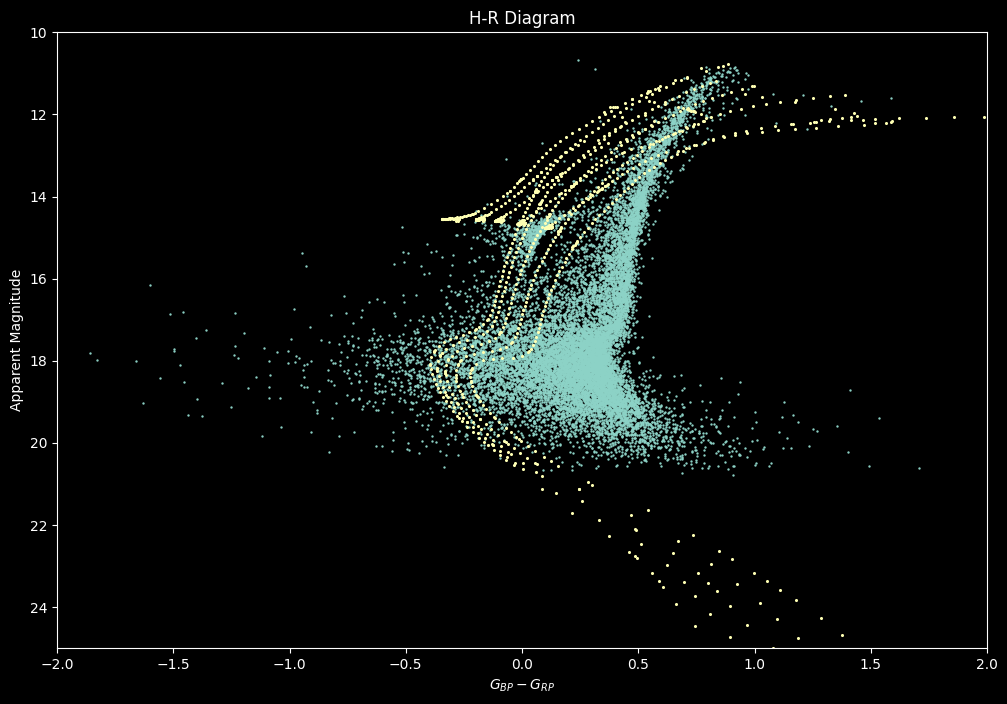

In [46]:
#Best fit: 12by, -1.2

with plt.style.context('dark_background'):
    plt.figure(figsize=(12,8))
    plt.scatter(xaxis,app_mag,s=0.5)
    plt.scatter((age12['G_BPmag']-age12['G_RPmag'])-1,age12['Gmag']+14.2,s=1.5)
    plt.xlabel('$G_{BP}-G_{RP}$')
    plt.ylim(10,25)
    plt.xlim(-2,2)
    plt.ylabel('Apparent Magnitude')
    plt.gca().invert_yaxis()
    plt.title('H-R Diagram')
plt.show()